# <center>**Compare Final Model Performances**</center>  
**Author**: Shirshak Aryal  
**Last Updated**: 20 July 2025

---
**Purpose:** This notebook serves as the culmination of the project, focusing on a comprehensive comparative analysis of the final trained XGBoost, Multi-Layer Perceptron (MLP), and Graph Neural Network (GNN) models. It involves loading the best-performing models and data splits, generating predictions, evaluating their performance using key metrics, and visualizing their predictive capabilities to draw conclusions on their suitability for `pGI50` prediction.

---

## 1. Setup Notebook
This section initializes the notebook environment by importing all necessary libraries, configuring system settings for performance and reproducibility, and establishing global parameters and file paths.

### 1.1 Configure Environment
This sub-section configures environment variables for CPU usage optimization and sets up PyTorch-specific thread management. It also ensures the project's root directory is added to the system path for proper custom module imports and includes a utility to capture the Git commit ID for reproducibility.

In [1]:
import os
import sys
import time

# General CPU Usage Optimization
os.environ["OMP_NUM_THREADS"] = "16"
os.environ["MKL_NUM_THREADS"] = "16"
os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["NUMEXPR_NUM_THREADS"] = "16"

# PyTorch-specific CPU Usage Optimization (if not using GPU exclusively)
import torch

try:
    torch.set_num_threads(16)
except RuntimeError as e:
    print(f"Warning: Could not set torch.set_num_threads.\n{e}")

try:
    torch.set_num_interop_threads(16)
except RuntimeError as e:
    print(f"Warning: Could not set torch.set_num_interop_threads.\n{e}")

print(f"PyTorch threads: {torch.get_num_threads()}")
print(f"PyTorch interop threads: {torch.get_num_interop_threads()}")

# Configure Project Path
from pathlib import Path

# Get the current working directory
current_dir = os.getcwd()

# Navigate up to the project root directory
project_root = Path(current_dir).parent.resolve()

# Add the project root to sys.path if it's not already there
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print(f"Project root added to sys.path: {project_root}")

# Utility for Git commit ID for reproducibility
import subprocess


def get_git_commit_hash():
    try:
        # Get the short commit hash
        commit_hash = (
            subprocess.check_output(["git", "rev-parse", "--short", "HEAD"])
            .strip()
            .decode("ascii")
        )
        return commit_hash
    except (subprocess.CalledProcessError, FileNotFoundError):
        return "unknown_commit"


current_commit_hash = get_git_commit_hash()
print(f"Current Git Commit ID: {current_commit_hash}")

# Suppress Warnings for Cleaner Output
import warnings

warnings.filterwarnings("ignore")

PyTorch threads: 16
PyTorch interop threads: 16
Project root added to sys.path: C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction
Current Git Commit ID: 3c64992


### 1.2. Import Libraries
All required Python libraries for data manipulation, molecular handling, PyTorch core functionalities, PyTorch Geometric, machine learning utilities, model loading, and plotting are imported here.

In [2]:
# Standard Library Imports
from datetime import datetime

# Core Data Science Libraries
import numpy as np
import pandas as pd

# Molecular Handling (RDKit) Libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage

# PyTorch Core Libraries
import torch.nn as nn  # Neural network modules like Linear, ReLU
import torch.nn.functional as F  # Functional interface for activations, e.g. F.relu
from torch.utils.data import (
    TensorDataset,
    DataLoader,
)  # For MLP

# PyTorch Geometric (PyG) Libraries
from torch_geometric.data import Data # The graph data object in PyG
from torch_geometric.loader import DataLoader as PyGDataLoader # PyG DataLoader for graphs
import torch_geometric.nn as pyg_nn # Common GNN layers (e.g., GCNConv, GraphSAGEConv)
import torch_geometric.utils as pyg_utils # Utility functions for graph manipulation

# Machine Learning Utilities
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation metrics
from sklearn.preprocessing import StandardScaler # For feature scaling

# Model Loading & Hyperparameter Optimization Libraries
import joblib # For loading XGBoost models
import optuna # For loading Optuna study results (best params)

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing Molecules
from IPython.display import display

# Conditional import for progress bars (tqdm)
tqdm_notebook_available = False # Initialize flag
try:
    from tqdm.notebook import tqdm
    tqdm.pandas() # Enable tqdm for pandas apply
    tqdm_notebook_available = True
    print("tqdm.notebook found and enabled for pandas.")
except ImportError:
    print("tqdm.notebook not found. Install with 'pip install tqdm'.")

# Custom MLP and GNN Model Classes
try:
    from src.models.mlp_models import MLP
    print("MLP model class imported successfully from src.models.mlp_models.")
except ImportError as e:
    print(f"ERROR: Could not import MLP class. Please check path and file: {e}")
    print("Ensure 'src/models/mlp_models.py' exists relative to your project root and contains the 'MLP' class.")

try:
    from src.models.gnn_models import GNN
    print("GNN model class imported successfully from src.models.gnn_models.")
except ImportError as e:
    print(f"ERROR: Could not import GNN class. Please check path and file: {e}")
    print("Ensure 'src/models/gnn_models.py' exists relative to your project root and contains the 'GNN' class.")

tqdm.notebook found and enabled for pandas.
MLP model class imported successfully from src.models.mlp_models.
GNN model class imported successfully from src.models.gnn_models.


### 1.3. Define Device (For PyTorch/PyG Models)
This sub-section explicitly defines the computing device (GPU if available, otherwise CPU) that will be used for model inference.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 1.4. Define Essential Directories
This sub-section predefines all necessary directory paths for loading data splits, pre-saved graph objects, and trained models.

In [4]:
# Define paths for data splits, PyG Data graph objects, final models, and Optuna studies
data_splits_dir = Path("../data/splits") # Universal data splits
pyg_data_graphs_dir = Path("../data/pyg_data_graphs") # Directory for saved PyG Data objects

xgboost_models_dir = Path("../models/xgb")
mlp_models_dir = Path("../models/mlp")
gnn_models_dir = Path("../models/gnn")

# Optuna database paths
optuna_studies_dir = Path("../studies")

print("\n--- Verifying Directory Existence ---")

directories_to_check = {
    "Data Splits Directory": data_splits_dir,
    "PyG Data Graphs Directory": pyg_data_graphs_dir,
    "XGBoost Models Directory": xgboost_models_dir,
    "MLP Models Directory": mlp_models_dir,
    "GNN Models Directory": gnn_models_dir,
    "Optuna Studies Database Directory": optuna_studies_dir
}

for name, path in directories_to_check.items():
    if path.is_dir():
        print(f"{name}: '{path.resolve()}' exists.")
    else:
        print(f"{name}: '{path.resolve()}' does NOT exist. Please ensure it is created and populated before running this notebook.")

print("--- Directory Verification Complete ---")

# Define full paths to your Optuna databases for loading
xgboost_optuna_db_path = f"sqlite:///{optuna_studies_dir / 'xgboost_study/xgb_optuna_study.db'}"
mlp_optuna_db_path = f"sqlite:///{optuna_studies_dir / 'mlp_study/mlp_optuna_study.db'}"
gnn_optuna_db_path = f"sqlite:///{optuna_studies_dir / 'gnn_study/gnn_optuna_study.db'}"

print("\nAll paths configured and necessary directories ensured.")


--- Verifying Directory Existence ---
Data Splits Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\data\splits' exists.
PyG Data Graphs Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\data\pyg_data_graphs' exists.
XGBoost Models Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\models\xgb' exists.
MLP Models Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\models\mlp' exists.
GNN Models Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\models\gnn' exists.
Optuna Studies Database Directory: 'C:\Users\Acer\Desktop\Projects for Data Science\Drug Gi50 Value Prediction\studies' exists.
--- Directory Verification Complete ---

All paths configured and necessary directories ensured.


## 2. Load Best Hyperparameters for Each Model
This section loads the optimized hyperparameters for XGBoost, MLP, and GNN models from their respective Optuna study databases. These parameters are crucial for re-initializing the best-performing models.

### 2.1. For XGBoost

In [5]:
print("\n--- Loading Best Hyperparameters from XGBoost Optuna Study ---")
xgboost_best_params = {}
try:
    xgboost_study = optuna.load_study(
        study_name="xgboost_regression_pGI50",
        storage=xgboost_optuna_db_path
    )
    xgboost_best_params = xgboost_study.best_trial.params
    print(f"\nXGBoost best hyperparameters: {xgboost_best_params}")
except Exception as e:
    print(f"\nERROR: Could not load XGBoost Optuna study.")


--- Loading Best Hyperparameters from XGBoost Optuna Study ---

XGBoost best hyperparameters: {'learning_rate': 0.00820193368271431, 'max_depth': 6, 'subsample': 0.9897893799354487, 'colsample_bytree': 0.7223075745984062, 'reg_alpha': 0.00012824377407451583, 'reg_lambda': 0.00397611471104642, 'gamma': 0.6775917319015243, 'n_estimators': 1148, 'min_child_weight': 9}


### 2.2. For MLP

In [6]:
print("\n--- Loading Best Hyperparameters from MLP Optuna Study ---")
mlp_best_params = {}
try:
    mlp_study = optuna.load_study(
        study_name="mlp_regression_pGI50",
        storage=mlp_optuna_db_path
    )
    mlp_best_params = mlp_study.best_trial.params
    print(f"\nMLP best hyperparameters: {mlp_best_params}")
except Exception as e:
    print(f"\nERROR: Could not load MLP Optuna study.")


--- Loading Best Hyperparameters from MLP Optuna Study ---

MLP best hyperparameters: {'hidden_size': 801, 'lr': 0.00016038661160511867, 'batch_size': 128, 'n_epochs': 195}


### 2.3. For GNN

In [7]:
print("\n--- Loading Best Hyperparameters from GNN Optuna Study ---")
gnn_best_params = {}
try:
    gnn_study = optuna.load_study(
        study_name="gnn_regression_pGI50",
        storage=gnn_optuna_db_path
    )
    gnn_best_params = gnn_study.best_trial.params
    print(f"\nGNN best hyperparameters: {gnn_best_params}")
except Exception as e:
    print(f"\nERROR: Could not load GNN Optuna study.")


--- Loading Best Hyperparameters from GNN Optuna Study ---

GNN best hyperparameters: {'hidden_channels': 999, 'lr': 0.0002654886343578734, 'batch_size': 128, 'n_epochs': 190, 'num_layers': 1, 'dropout_rate': 0.12998376396007172, 'weight_decay': 4.855663649252953e-08}


## 3. Load Universal Test Data Splits
This section loads the universal test dataset (features and target) that will be used to evaluate all models consistently, ensuring an unbiased comparison.

In [8]:
print(f"Loading universal test data splits from: {data_splits_dir}")
X_test = pd.read_parquet(data_splits_dir / "X_test.parquet")
y_test = pd.read_parquet(data_splits_dir / "y_test.parquet")

print(f"\nX_test shape: {X_test.shape}")
display(X_test.head(3))
print(f"\ny_test shape: {y_test.shape}")
display(y_test.head(3))

Loading universal test data splits from: ..\data\splits

X_test shape: (2812, 2268)


molregno                                   canonical_smiles  \
0    700930  CN(C)c1ccc(/C=C(/SCc2ccc(F)cc2)C(=O)c2ccc(Br)c...   
1    575507      C=C(C)C(=O)c1ccc(OCc2nc(-c3ccc(F)cc3)no2)cc1C   
2   2551069  CCN1CCN(c2cccc(Nc3ncc4scc(-c5cccc(NS(C)(=O)=O)...   

   num_activities  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
0               2          13.164990       13.164990           0.026576   
1               1          12.960960       12.960960           0.084736   
2               2          11.639268       11.639268           0.521611   

   MinEStateIndex       qed        SPS    MolWt  ...  morgan_fp_2038  \
0       -0.262559  0.279519  11.379310  470.407  ...               0   
1       -0.328937  0.481883  10.576923  352.365  ...               0   
2       -3.351425  0.376574  14.857143  508.673  ...               0   

   morgan_fp_2039  morgan_fp_2040  morgan_fp_2041  morgan_fp_2042  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   

   morgan_fp_2043  morgan_fp_2044  morgan_fp_2045  morgan_fp_2046  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   

   morgan_fp_2047  
0               0  
1               0  
2               0  

[3 rows x 2268 columns]


y_test shape: (2812, 1)


pGI50
5860   5.150515
4724   5.337242
16937  6.112231

## 4. Prepare Test Data for All Models
This section performs model-specific preprocessing on the universal test data to ensure it is in the correct format for each model's inference.

### 4.1. Prepare Test Data for XGBoost
Identifier columns are dropped, and the test data is converted to a NumPy array, as required by the XGBoost model for prediction.

In [9]:
print("\nPreparing test data for XGBoost (dropping identifiers)...")
# Ensure 'molregno' and 'canonical_smiles' are dropped if still present
columns_to_drop_xgb = []
if 'molregno' in X_test.columns:
    columns_to_drop_xgb.append('molregno')
if 'canonical_smiles' in X_test.columns:
    columns_to_drop_xgb.append('canonical_smiles')

if columns_to_drop_xgb:
    X_test_xgb = X_test.drop(columns=columns_to_drop_xgb)
else:
    # If columns are already absent, make a copy
    X_test_xgb = X_test.copy()

print(f"X_test_xgb shape (for XGBoost): {X_test_xgb.shape}")
print(f"Columns in X_test_xgb: {X_test_xgb.columns.tolist()[:5]}...") # Print first 5 columns to verify


Preparing test data for XGBoost (dropping identifiers)...
X_test_xgb shape (for XGBoost): (2812, 2266)
Columns in X_test_xgb: ['num_activities', 'MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex']...


### 4.2. Prepare Test Data for MLP
The test data for the MLP model is prepared by fitting a `StandardScaler` on training data, scaling the test features, and converting them into PyTorch tensors suitable for the MLP.

#### 4.2.1. Load Training Data to Fit Scaler

In [10]:
print("\n--- Loading Training Data for StandardScaler and fitting ---")
X_train_path = data_splits_dir / "X_train.parquet"
try:
    # Extract X_train for MLP, dropping the identifier columns
    X_train_mlp = pd.read_parquet(X_train_path).drop(columns=['molregno', 'canonical_smiles'], errors='ignore')

    print(f"X_train_mlp shape for scaler fitting: {X_train_mlp.shape}")

    # Initialize and fit the StandardScaler on the training features
    mlp_scaler = StandardScaler()
    mlp_scaler.fit(X_train_mlp) # Fit only on X_train_mlp

    print("StandardScaler fitted successfully on training data.")
except FileNotFoundError:
    print(f"ERROR: Training data not found at {X_train_path}. Cannot re-fit StandardScaler.")
    print("Please ensure original training data file is in the correct directory.")
    mlp_scaler = None
except Exception as e:
    print(f"An unexpected error occurred while loading training data or fitting scaler: {e}")
    mlp_scaler = None


--- Loading Training Data for StandardScaler and fitting ---
X_train_mlp shape for scaler fitting: (13119, 2266)
StandardScaler fitted successfully on training data.


#### 4.2.2. Prepare with Scaled Test Data

In [11]:
print("\nPreparing test data for MLP (dropping identifiers, scaling, and converting to PyTorch tensors)...")
mlp_features_df = X_test.copy()

# Ensure 'molregno' and 'canonical_smiles' are dropped if still present in the universal X_test
columns_to_drop_mlp = []
if 'molregno' in mlp_features_df.columns:
    columns_to_drop_mlp.append('molregno')
if 'canonical_smiles' in mlp_features_df.columns:
    columns_to_drop_mlp.append('canonical_smiles')

if columns_to_drop_mlp:
    mlp_features_df = mlp_features_df.drop(columns=columns_to_drop_mlp)

# Convert the cleaned DataFrame to PyTorch tensors
if mlp_scaler is None:
    print("WARNING: mlp_scaler is not available.")
else:
    print("Applying StandardScaler transformation to MLP test features...")
    mlp_features_scaled_np = mlp_scaler.transform(mlp_features_df.values)
    # Convert the scaled NumPy array to PyTorch tensor
    X_test_tensor = torch.tensor(mlp_features_scaled_np, dtype=torch.float32)

y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32) # y_test remains unchanged

# Create DataLoader for MLP
mlp_batch_size = mlp_best_params.get('batch_size')
test_dataset_mlp = TensorDataset(X_test_tensor, y_test_tensor)
final_test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=mlp_batch_size, shuffle=False)

print(f"X_test_tensor shape: {X_test_tensor.shape}")
print(f"y_test_tensor shape: {y_test_tensor.shape}")
print(f"Number of batches in final_test_loader_mlp: {len(final_test_loader_mlp)}")


Preparing test data for MLP (dropping identifiers, scaling, and converting to PyTorch tensors)...
Applying StandardScaler transformation to MLP test features...
X_test_tensor shape: torch.Size([2812, 2266])
y_test_tensor shape: torch.Size([2812, 1])
Number of batches in final_test_loader_mlp: 22


### 4.3. Prepare Test Data for GNN
The pre-saved PyTorch Geometric graph objects for the test set are loaded and converted into a PyTorch Geometric `DataLoader` for efficient batch processing during GNN inference.

In [12]:
print("\nPreparing test data for GNN (loading pre-created PyTorch Geometric Data objects)...")
pyg_test_data_filename = "test_data_list.pt"
path_to_pyg_test_data = pyg_data_graphs_dir / pyg_test_data_filename

test_data_list = []
try:
    test_data_list = torch.load(path_to_pyg_test_data, weights_only=False)
    print(f"Loaded {len(test_data_list)} GNN test graphs from: {path_to_pyg_test_data}")
except FileNotFoundError:
    print(f"ERROR: GNN test data not found at {path_to_pyg_test_data.resolve()}.")
    print("Please ensure the pre-created PyG Data objects for the test set are saved correctly at this location.")
    print("Cannot proceed with GNN evaluation without this data.")
except Exception as e:
    print(f"An unexpected error occurred while loading GNN test data: {e}")
    print("Cannot proceed with GNN evaluation.")

if test_data_list: # Only create DataLoader if data was loaded successfully
    gnn_batch_size = gnn_best_params.get('batch_size')
    final_test_loader_gnn = PyGDataLoader(test_data_list, batch_size=gnn_batch_size, shuffle=False)
    print(f"Number of batches in final_test_loader_gnn: {len(final_test_loader_gnn)}")
else:
    print("GNN DataLoader could not be created due to missing test data.")


Preparing test data for GNN (loading pre-created PyTorch Geometric Data objects)...
Loaded 2812 GNN test graphs from: ..\data\pyg_data_graphs\test_data_list.pt
Number of batches in final_test_loader_gnn: 22


## 5. Load Best Models
This section loads the trained models for XGBoost, MLP, and GNN, ensuring they are ready for making predictions on the test set.

### 5.1. Load Best XGBoost Model
The best-performing XGBoost model, saved from its dedicated training notebook, is loaded using `joblib`.

In [13]:
print("\n--- Loading Best XGBoost Model ---")

xgboost_model = None
xgboost_model_filename = "final_best_xgboost_model_271d2f4.joblib"
path_to_xgboost_model = xgboost_models_dir / xgboost_model_filename

try:
    xgboost_model = joblib.load(path_to_xgboost_model)
    print(f"XGBoost model loaded successfully from: {path_to_xgboost_model}")
except FileNotFoundError:
    print(f"ERROR: XGBoost model not found at {path_to_xgboost_model}.")
    print("Please ensure the best XGBoost model is saved in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred while loading XGBoost model: {e}")


--- Loading Best XGBoost Model ---
XGBoost model loaded successfully from: ..\models\xgb\final_best_xgboost_model_271d2f4.joblib


### 5.2. Load Best MLP Model
The MLP model's architecture is reinitialized using its best hyperparameters, and then its trained state dictionary is loaded to restore its learned weights.

In [14]:
print("\n--- Loading Best MLP Model ---")
mlp_model = None
mlp_model_filename = "final_best_mlp_model_5b6c756.pt"
path_to_mlp_model = mlp_models_dir / mlp_model_filename

try:
    # Instantiate the MLP model with best hyperparameters loaded from Optuna
    mlp_input_size = X_test_tensor.shape[1]
    mlp_output_size = 1

    mlp_model = MLP(
        input_size=mlp_input_size,
        hidden_size=mlp_best_params.get('hidden_size'),
        output_size=mlp_output_size,
    ).to(device)

    mlp_model.load_state_dict(torch.load(path_to_mlp_model, map_location=device))
    mlp_model.eval() # Set model to evaluation mode
    print(f"MLP model loaded successfully from: {path_to_mlp_model} and set to evaluation mode.")
except FileNotFoundError:
    print(f"ERROR: MLP model not found at {path_to_mlp_model.resolve()}.")
    print("Please ensure the best MLP model is saved in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred while loading MLP model: {e}")


--- Loading Best MLP Model ---
MLP model loaded successfully from: ..\models\mlp\final_best_mlp_model_5b6c756.pt and set to evaluation mode.


### 5.3. Load Best GNN Model
The GNN model's architecture is reinitialized with its best hyperparameters, and its trained state dictionary is loaded to restore its learned weights, preparing it for inference.

In [15]:
print("\n--- Loading Best GNN Model ---")

gnn_model = None
gnn_model_filename = "final_best_gnn_model_271d2f4.pt"
path_to_gnn_model = gnn_models_dir / gnn_model_filename

try:
    if not test_data_list:
        print("WARNING: GNN test data not loaded, cannot infer feature dimensions for GNN model instantiation.")
        
    else:
        # Instantiate the GNN model with best hyperparameters loaded from Optuna
        gnn_node_feature_dim = test_data_list[0].x.shape[1]
        gnn_global_feature_dim = test_data_list[0].global_features.shape[1]
        gnn_output_size = 1
        
        gnn_model = GNN(
            node_feature_dim=gnn_node_feature_dim,
            global_feature_dim=gnn_global_feature_dim,
            hidden_channels=gnn_best_params.get('hidden_channels'),
            num_layers=gnn_best_params.get('num_layers'),
            dropout_rate=gnn_best_params.get('dropout_rate')
        ).to(device)
    
        gnn_model.load_state_dict(torch.load(path_to_gnn_model, map_location=device))
        gnn_model.eval() # Set model to evaluation mode
        print(f"GNN model loaded successfully from: {path_to_gnn_model} and set to evaluation mode.")
except FileNotFoundError:
    print(f"ERROR: GNN model not found at {path_to_gnn_model}.")
    print("Please ensure the best GNN model is saved in the correct directory.")
except Exception as e:
    print(f"An unexpected error occurred while loading GNN model: {e}")


--- Loading Best GNN Model ---
GNN model loaded successfully from: ..\models\gnn\final_best_gnn_model_271d2f4.pt and set to evaluation mode.


## 6. Make Predictions Using Each Model
This section generates predictions on the unseen test dataset using each of the loaded, best-performing models.

### 6.1. Make Predictions Using XGBoost
Predictions are generated using the trained XGBoost model on the prepared test data.

In [16]:
xgboost_predictions = None
if xgboost_model is not None:
    print("Generating predictions on the test data using the XGBoost model...")
    xgboost_predictions = xgboost_model.predict(X_test_xgb)
    print("XGBoost predictions generated.")
else:
    print("XGBoost model not loaded. Skipping predictions.")

Generating predictions on the test data using the XGBoost model...
XGBoost predictions generated.


### 6.2. Make Predictions Using MLP
Predictions are generated using the trained MLP model on the scaled and tensor-converted test data.

In [17]:
mlp_predictions = []
mlp_true_targets = []
if mlp_model is not None and final_test_loader_mlp is not None:
    print("Generating predictions on and collecting true targets from the test data using the MLP model...")
    mlp_model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        for X_batch, y_batch in final_test_loader_mlp:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = mlp_model(X_batch)
            mlp_predictions.extend(outputs.squeeze().cpu().numpy())
            mlp_true_targets.extend(y_batch.squeeze().cpu().numpy()) # Collect true targets
    mlp_predictions = np.array(mlp_predictions)
    mlp_true_targets = np.array(mlp_true_targets) # Convert to numpy array
    print("MLP predictions generated and true targets collected.")
else:
    print("MLP model or DataLoader not loaded. Skipping predictions and target collection.")

Generating predictions on and collecting true targets from the test data using the MLP model...
MLP predictions generated and true targets collected.


### 6.3. Make Predictions Using GNN
Predictions are generated using the trained GNN model on the PyTorch Geometric test data loader.

In [18]:
gnn_predictions = []
gnn_true_targets = []
if gnn_model is not None and final_test_loader_gnn is not None:
    print("Generating predictions on and collecting true targets from the test data using the MLP model...")
    gnn_model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        for data_batch in final_test_loader_gnn:
            data_batch = data_batch.to(device)
            y_batch = data_batch.y.to(device)

            outputs = gnn_model(data_batch)
            gnn_predictions.extend(outputs.squeeze().cpu().numpy())
            gnn_true_targets.extend(y_batch.squeeze().cpu().numpy()) # Collect true targets
    gnn_predictions = np.array(gnn_predictions)
    gnn_true_targets = np.array(gnn_true_targets) # Convert to numpy array
    print("GNN predictions generated and true targets collected.")
else:
    print("GNN model or DataLoader not loaded. Skipping predictions and target collection.")

Generating predictions on and collecting true targets from the test data using the MLP model...
GNN predictions generated and true targets collected.


## 7. Evaluate Performance of Each Model
This section calculates and stores the key performance metrics (RMSE and R2 score) for each model based on their predictions on the test set.

In [19]:
# Define dictionary to store all metrics
model_metrics = {}

### 7.1. Evaluate XGBoost Performance
The RMSE and R2 scores for the XGBoost model's predictions are calculated against the true test values.

In [20]:
if xgboost_predictions is not None:
    print("\nEvaluating XGBoost Model...")
    # For XGBoost, use the universal y_test
    rmse_xgb = np.sqrt(mean_squared_error(y_test, xgboost_predictions))
    r2_xgb = r2_score(y_test, xgboost_predictions)

    print(f"XGBoost Test RMSE: {rmse_xgb:.4f}")
    print(f"XGBoost Test R2: {r2_xgb:.4f}")
    model_metrics['XGBoost'] = {'RMSE': rmse_xgb, 'R2': r2_xgb}
else:
    print("\nSkipping XGBoost evaluation as predictions are not available.")


Evaluating XGBoost Model...
XGBoost Test RMSE: 0.6957
XGBoost Test R2: 0.4951


### 7.2. Evaluate MLP Performance
The RMSE and R2 scores for the MLP model's predictions are calculated against the true test values.

In [21]:
if len(mlp_predictions) > 0 and len(mlp_true_targets) > 0:
    print("\nEvaluating MLP Model...")
    rmse_mlp = np.sqrt(mean_squared_error(mlp_true_targets, mlp_predictions))
    r2_mlp = r2_score(mlp_true_targets, mlp_predictions)

    print(f"MLP Test RMSE: {rmse_mlp:.4f}")
    print(f"MLP Test R2: {r2_mlp:.4f}")
    model_metrics['MLP'] = {'RMSE': rmse_mlp, 'R2': r2_mlp}
else:
    print("\nSkipping MLP evaluation as predictions or true targets are not available.")


Evaluating MLP Model...
MLP Test RMSE: 0.6408
MLP Test R2: 0.5715


### 7.3. Evaluate GNN Performance
The RMSE and R2 scores for the GNN model's predictions are calculated against the true test values.

In [22]:
if len(gnn_predictions) > 0 and len(gnn_true_targets) > 0:
    print("\nEvaluating GNN Model...")
    rmse_gnn = np.sqrt(mean_squared_error(gnn_true_targets, gnn_predictions))
    r2_gnn = r2_score(gnn_true_targets, gnn_predictions)

    print(f"GNN Test RMSE: {rmse_gnn:.4f}")
    print(f"GNN Test R2: {r2_gnn:.4f}")
    model_metrics['GNN'] = {'RMSE': rmse_gnn, 'R2': r2_gnn}
else:
    print("\nSkipping GNN evaluation as predictions or true targets are not available.")


Evaluating GNN Model...
GNN Test RMSE: 0.6114
GNN Test R2: 0.6100


## 8. Summarize and Visualize Comparative Model Performances
This final section consolidates the evaluation metrics into a comparative table and generates visual plots to provide a comprehensive overview of each model's predictive performance.

### 8.1. Summarize Performance Metrics
The calculated RMSE and R2 scores for all models are presented in a clear, comparative DataFrame to highlight their relative performance.

In [23]:
print("\n--- Summarizing Model Performance for Comparison ---")

# Convert the model_metrics dictionary into a Pandas DataFrame
# Transpose it to have models as rows and metrics as columns
metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index')

print("\nComparative Model Performance on Test Set:")
display(metrics_df.round(4)) # Display with 4 decimal places

print("\n--- Model Performance Summary Complete ---")


--- Summarizing Model Performance for Comparison ---

Comparative Model Performance on Test Set:


RMSE      R2
XGBoost  0.6957  0.4951
MLP      0.6408  0.5715
GNN      0.6114  0.6100


--- Model Performance Summary Complete ---


### 8.2. Plot Predictions vs True Values
This sub-section generates parity plots for each model, visually comparing their predicted `pGI50` values against the true `pGI50` values on the test set. These plots help assess the overall fit and any systematic deviations from the ideal prediction line.


--- Generating Model Performance Visualizations ---


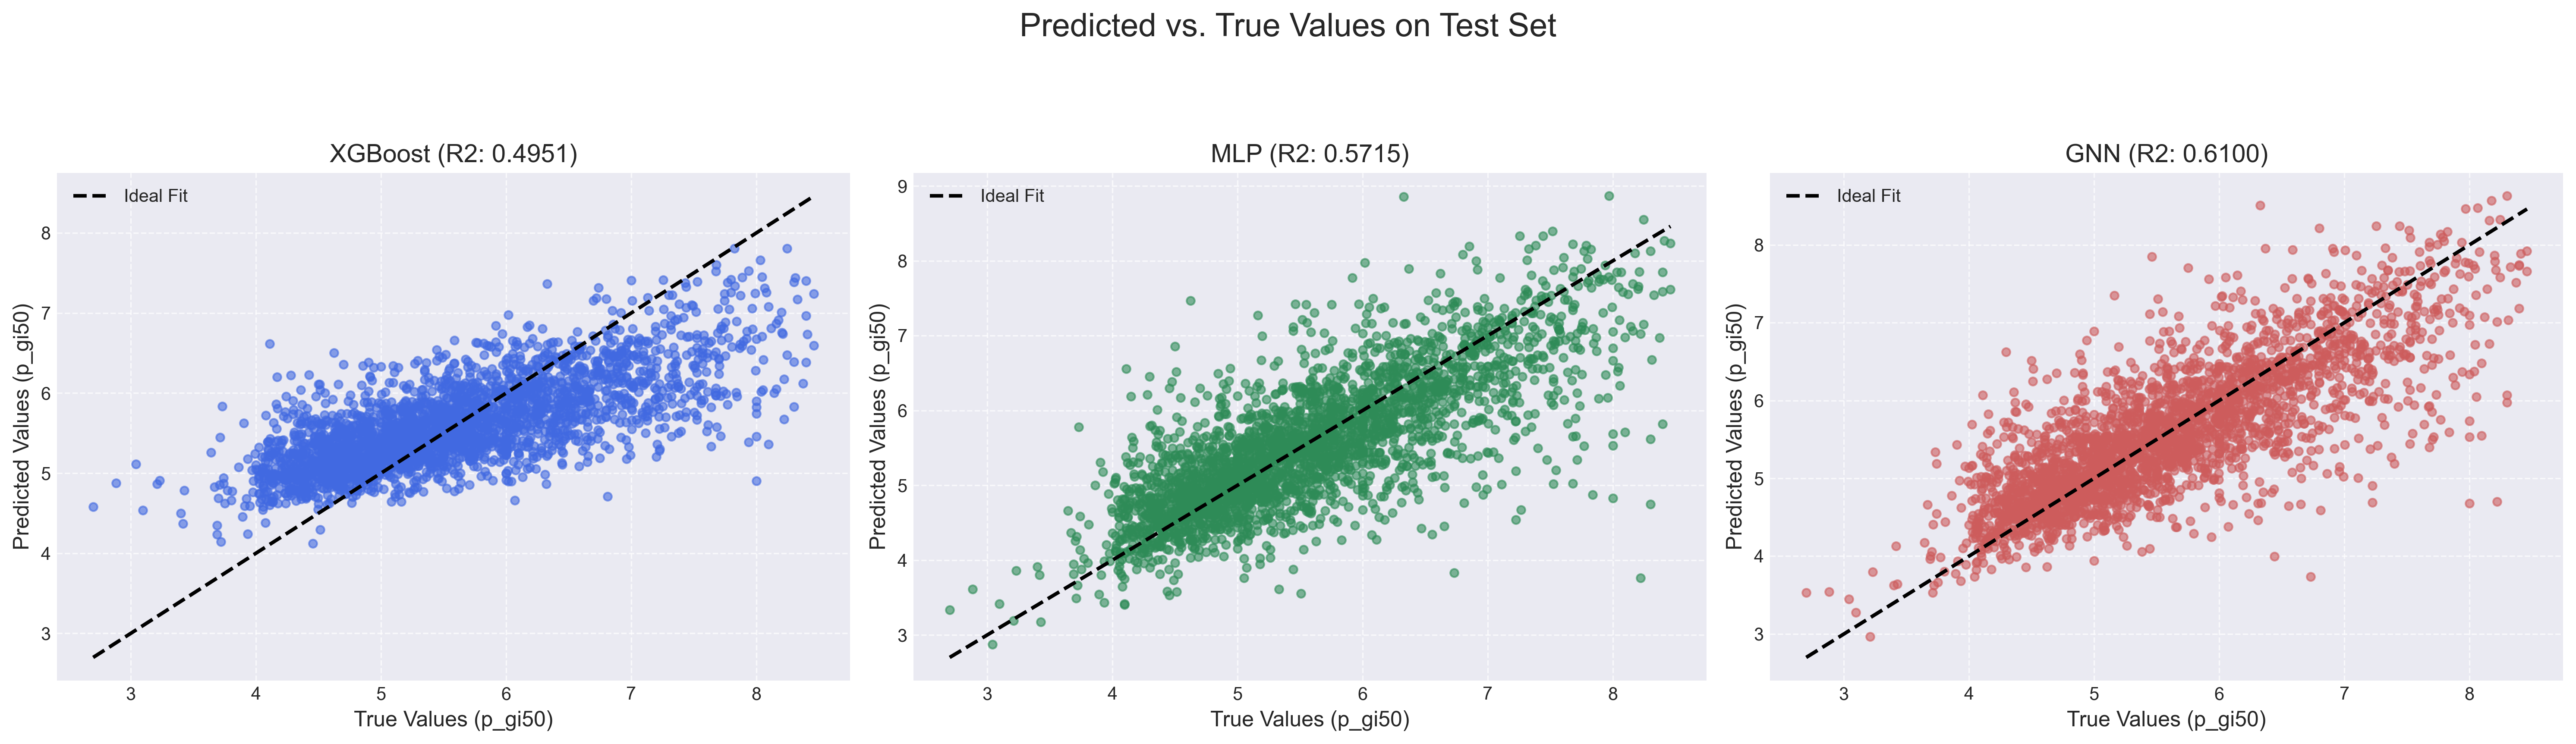


--- Model Performance Visualizations Complete ---


In [24]:
print("\n--- Generating Model Performance Visualizations ---")

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 300 # High resolution for better clarity
plt.rcParams['savefig.dpi'] = 300 # High resolution for saving

fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # 1 row, 3 columns for 3 models
fig.suptitle('Predicted vs. True Values on Test Set', fontsize=18)

# XGBoost Plot
if xgboost_predictions is not None:
    ax = axes[0]
    ax.scatter(y_test, xgboost_predictions, alpha=0.6, s=20, color='royalblue')
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')
    ax.set_title(f'XGBoost (R2: {model_metrics["XGBoost"]["R2"]:.4f})', fontsize=14)
    ax.set_xlabel('True Values (p_gi50)', fontsize=12)
    ax.set_ylabel('Predicted Values (p_gi50)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[0].set_title('XGBoost (Not Available)')
    axes[0].axis('off')


# MLP Plot
if len(mlp_predictions) > 0 and len(mlp_true_targets) > 0:
    ax = axes[1]
    ax.scatter(mlp_true_targets, mlp_predictions, alpha=0.6, s=20, color='seagreen')
    ax.plot([mlp_true_targets.min(), mlp_true_targets.max()], [mlp_true_targets.min(), mlp_true_targets.max()], 'k--', lw=2, label='Ideal Fit')
    ax.set_title(f'MLP (R2: {model_metrics["MLP"]["R2"]:.4f})', fontsize=14)
    ax.set_xlabel('True Values (p_gi50)', fontsize=12)
    ax.set_ylabel('Predicted Values (p_gi50)', fontsize=12) # Share y-label with first plot
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[1].set_title('MLP (Not Available)')
    axes[1].axis('off')


# GNN Plot
if len(gnn_predictions) > 0 and len(gnn_true_targets) > 0:
    ax = axes[2]
    ax.scatter(gnn_true_targets, gnn_predictions, alpha=0.6, s=20, color='indianred')
    ax.plot([gnn_true_targets.min(), gnn_true_targets.max()], [gnn_true_targets.min(), gnn_true_targets.max()], 'k--', lw=2, label='Ideal Fit')
    ax.set_title(f'GNN (R2: {model_metrics["GNN"]["R2"]:.4f})', fontsize=14)
    ax.set_xlabel('True Values (p_gi50)', fontsize=12)
    ax.set_ylabel('Predicted Values (p_gi50)', fontsize=12) # Share y-label with first plot
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[2].set_title('GNN (Not Available)')
    axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.9]) # Adjust layout to prevent title overlap
plt.show()

print("\n--- Model Performance Visualizations Complete ---")

#### 8.2.1. Plot Analysis
**XGBoost**  
The XGBoost model's parity plot shows a tight central cluster of predictions, indicating strong agreement between predicted and true values for the majority of the data. However, the cluster is slightly elongated horizontally and not perfectly aligned with the ideal fit line, suggesting a minor systematic bias. Additionally, scattered points along the length of this central cluster (rather than increasing thickness) indicate isolated, larger prediction errors across the range.

**MLP**  
For the MLP model, the central cluster of predictions is notably tight, well-centered, and closely parallel to the ideal fit line, demonstrating a strong linear relationship and minimal bias for the core data. A subtle narrowing of the cluster towards the top-right corner, along with scattered points predominantly in that region, suggests a slight reduction in predictive precision or increased variability for higher `pGI50` values.

**GNN**  
The GNN model's parity plot is remarkably similar to the MLP, showcasing a very tight and well-aligned central cluster of predictions. This indicates excellent overall fit and low bias. The key difference lies in the scattered points, which appear slightly closer to the main cluster as compared to the MLP, suggesting marginally improved robustness or fewer significant outliers.


### 8.3. Plot Residuals vs Predictions
This sub-section generates residual plots for each model, displaying the difference between true and predicted `pGI50` values (i.e., residue) against the predicted values. These plots are crucial for identifying patterns in the errors, such as bias or heteroscedasticity, providing deeper insights into model behavior.


--- Analyzing Model Residuals ---


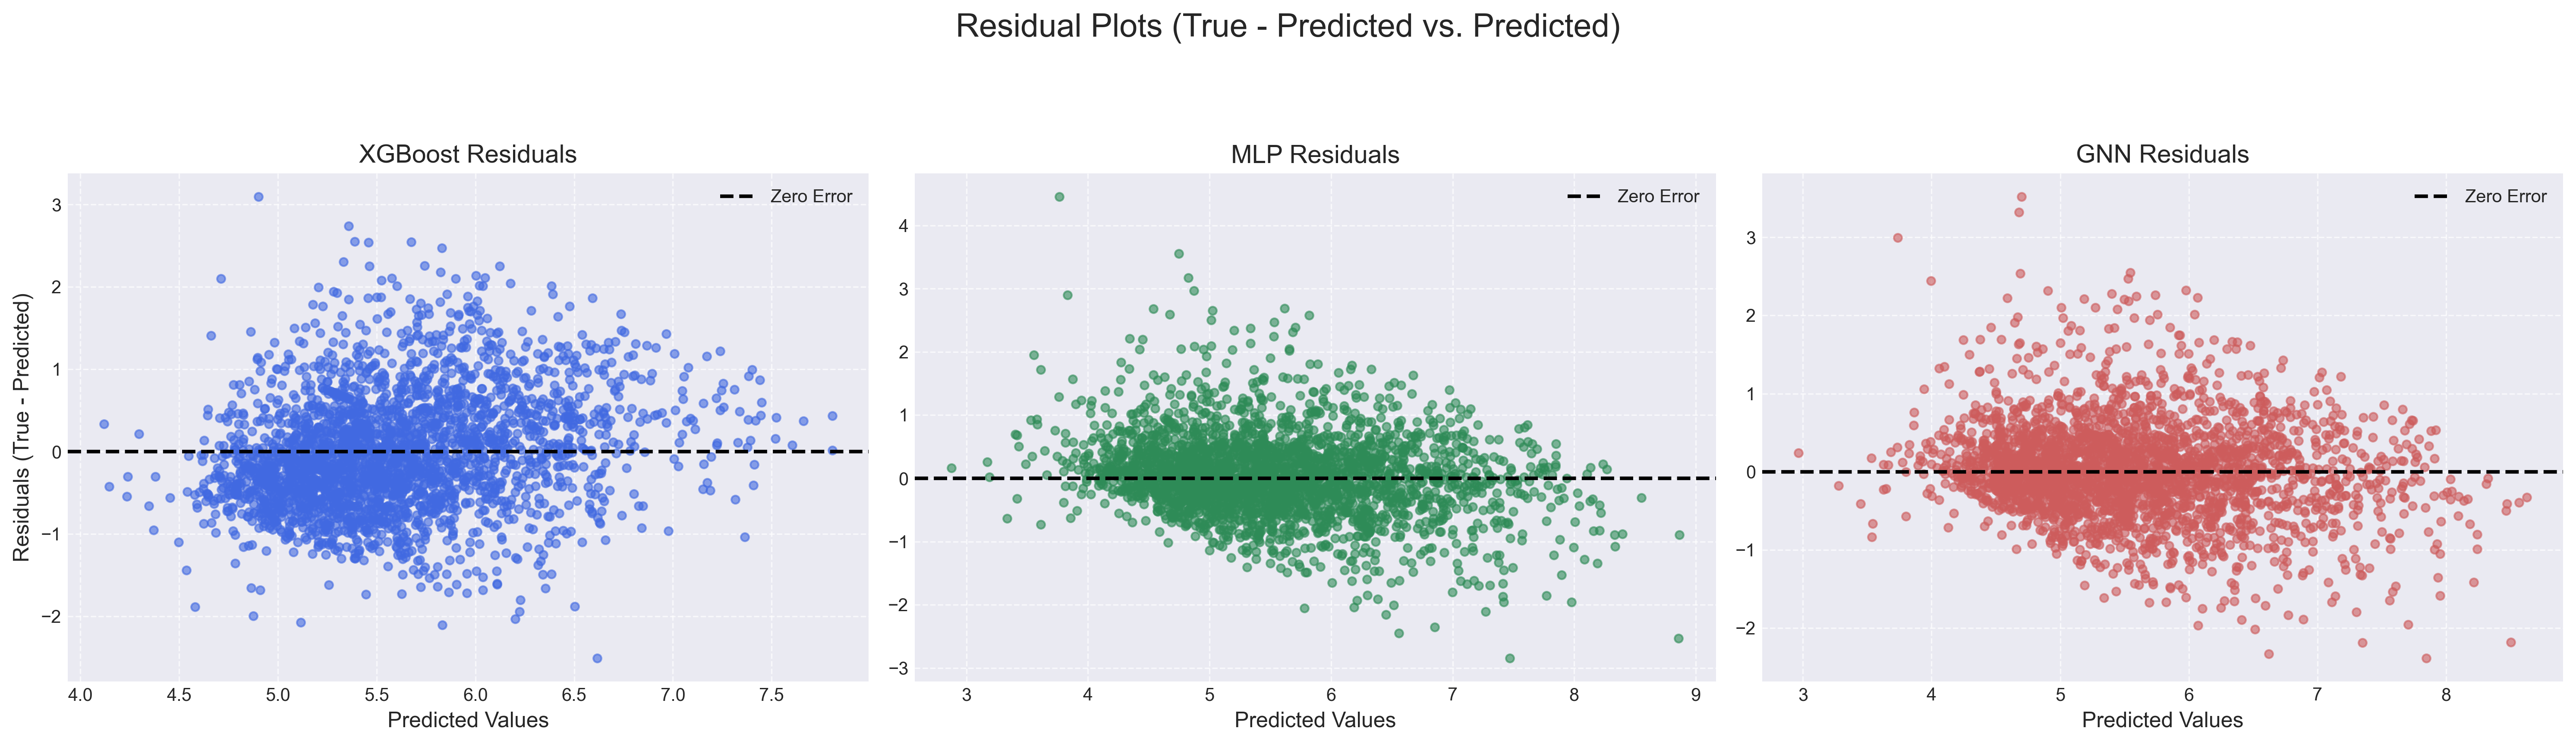


--- Residual Analysis Visualizations Complete ---


In [25]:
print("\n--- Analyzing Model Residuals ---")

# Set up the plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Residual Plots (True - Predicted vs. Predicted)', fontsize=18)

# XGBoost Residual Plot
if xgboost_predictions is not None:
    ax = axes[0]
    # Ensure both y_test and xgboost_predictions are NumPy arrays for direct subtraction
    residuals_xgb = y_test.values.flatten() - xgboost_predictions.flatten()

    ax.scatter(xgboost_predictions.flatten(), residuals_xgb, alpha=0.6, s=20, color='royalblue')
    ax.axhline(y=0, color='k', linestyle='--', lw=2, label='Zero Error')
    ax.set_title('XGBoost Residuals', fontsize=14)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.set_ylabel('Residuals (True - Predicted)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[0].set_title('XGBoost Residuals (Not Available)')
    axes[0].axis('off')


# MLP Residual Plot
if len(mlp_predictions) > 0 and len(mlp_true_targets) > 0:
    ax = axes[1]
    residuals_mlp = np.array(mlp_true_targets).flatten() - np.array(mlp_predictions).flatten()
    ax.scatter(np.array(mlp_predictions).flatten(), residuals_mlp, alpha=0.6, s=20, color='seagreen')
    ax.axhline(y=0, color='k', linestyle='--', lw=2, label='Zero Error')
    ax.set_title('MLP Residuals', fontsize=14)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[1].set_title('MLP Residuals (Not Available)')
    axes[1].axis('off')


# GNN Residual Plot
if len(gnn_predictions) > 0 and len(gnn_true_targets) > 0:
    ax = axes[2]
    residuals_gnn = np.array(gnn_true_targets).flatten() - np.array(gnn_predictions).flatten()
    ax.scatter(np.array(gnn_predictions).flatten(), residuals_gnn, alpha=0.6, s=20, color='indianred')
    ax.axhline(y=0, color='k', linestyle='--', lw=2, label='Zero Error')
    ax.set_title('GNN Residuals', fontsize=14)
    ax.set_xlabel('Predicted Values', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
else:
    axes[2].set_title('GNN Residuals (Not Available)')
    axes[2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

print("\n--- Residual Analysis Visualizations Complete ---")

#### 8.3.1. Plot Analysis
**XGBoost**  
The residual plot for the XGBoost model displays a central cluster resembling an eye shape, positioned slightly below and to the left of the `y=0` line's center. This slight offset suggests a minor systematic bias (e.g., slight underprediction on average). Notably, residuals begin to spread out from the top-right corner of this "eye," fanning outwards and then seemingly converging back towards the `y=0` line. This pattern suggests a form of **heteroscedasticity**, where the variance of the errors changes with the predicted value, potentially narrowing at the extremes. The presence of more distant scattered points, particularly directly above the central cluster and somewhat clustered in the bottom-left/center, further indicates areas of higher prediction error.

**MLP**  
The MLP model's residual plot features a main cluster resembling a small fish, aligned lengthwise with the `y=0` line and exhibiting a slight taper towards the left (lower predicted values). The scattered residuals primarily appear within confined, angled restrictions (from top-left to bottom-right) relative to the central cluster. This distinct pattern suggests a structured error distribution that is not entirely random, potentially indicating a non-constant variance or an uncaptured interaction, though not like a "fan" seen in heteroscedasticity.

**GNN**
The GNN model's residual plot is almost identical in pattern to the MLP, but the central "fish" cluster appears marginally "thicker" and the angled restrictions of the scattered dots are slightly wider. This indicates a very similar error distribution to the MLP but with a subtly increased spread in the residuals overall. Like the MLP, the pattern suggests some non-randomness in the error variance or an uncaptured relationship.


### 8.4. Visualize Molecular Predictions with Structures
This section delves deeper into the models' predictive behavior by visualizing actual molecular structures from the test set. Examples that illustrate the comparative strengths and weaknesses of the GNN against the tabular models (XGBoost, MLP) are highlighted, providing a direct visual correlation to the quantitative performance metrics observed in previous sections.
Molecules where:
* The GNN significantly outperformed tabular models
* All models struggled
* A tabular model surprisingly yielded more accurate predictions than the GNN
* The GNN predicted pGI50 values with minimum error  

are examined. This allows for a clear, molecule-by-molecule illustration of the models' performance nuances across different scenarios within the test set.

#### 8.4.1. Consolidate Test Predictions for Visualization
Before proceeding with the detailed molecular visualizations, all relevant test set information is consolidated into a single pandas DataFrame. This includes the SMILES strings for each molecule, their true `pGI50` values, and the predictions generated by the XGBoost, MLP, and GNN models. Additionally, the absolute prediction error is calculated for each model on every molecule, which will be crucial for identifying specific cases for visualization.

In [26]:
test_results_df = pd.DataFrame(
    {
        "SMILES": X_test["canonical_smiles"].values,
        "True_pGI50": y_test["pGI50"].values,
        "XGB_Prediction": xgboost_predictions.flatten(),
        "MLP_Prediction": mlp_predictions.flatten(),
        "GNN_Prediction": gnn_predictions.flatten(),
    }
)

# Calculate the absolute error for the predictions
test_results_df['XGB_Abs_Error'] = np.abs(test_results_df['True_pGI50'] - test_results_df['XGB_Prediction'])
test_results_df['MLP_Abs_Error'] = np.abs(test_results_df['True_pGI50'] - test_results_df['MLP_Prediction'])
test_results_df['GNN_Abs_Error'] = np.abs(test_results_df['True_pGI50'] - test_results_df['GNN_Prediction'])

display(test_results_df.head(3))

SMILES  True_pGI50  \
0  CN(C)c1ccc(/C=C(/SCc2ccc(F)cc2)C(=O)c2ccc(Br)c...    5.150515   
1      C=C(C)C(=O)c1ccc(OCc2nc(-c3ccc(F)cc3)no2)cc1C    5.337242   
2  CCN1CCN(c2cccc(Nc3ncc4scc(-c5cccc(NS(C)(=O)=O)...    6.112231   

   XGB_Prediction  MLP_Prediction  GNN_Prediction  XGB_Abs_Error  \
0        5.217939        4.935259        5.385645       0.067424   
1        5.315832        5.678551        5.440767       0.021410   
2        6.277576        6.243575        6.399362       0.165346   

   MLP_Abs_Error  GNN_Abs_Error  
0       0.215255       0.235131  
1       0.341309       0.103525  
2       0.131344       0.287131

#### 8.4.2. Define Helper Function for Molecule Visualization
To streamline the process of displaying molecular structures with their associated true values, predictions, and errors, a helper function is defined here. This function utilizes RDKit's drawing capabilities to render 2D molecular structures and annotates them with key performance metrics for easy comparative analysis.

In [57]:
def display_molecules_with_predictions(df_subset, title):
    mols = [Chem.MolFromSmiles(s) for s in df_subset["SMILES"].tolist()]
    legends = [
        f"True: {row['True_pGI50']:.2f}\n"
        f"GNN: {row['GNN_Prediction']:.2f} (Err:{row['GNN_Abs_Error']:.2f})\n"
        f"MLP: {row['MLP_Prediction']:.2f} (Err:{row['MLP_Abs_Error']:.2f})\n"
        f"XGB: {row['XGB_Prediction']:.2f} (Err:{row['XGB_Abs_Error']:.2f})"
        for idx, row in df_subset.iterrows()
    ]

    valid_mols = [m for m in mols if m is not None]
    valid_legends = [leg for i, leg in enumerate(legends) if mols[i] is not None]

    if valid_mols:
        print(f"\n### {title}")
        img = MolsToGridImage(
            valid_mols,
            molsPerRow=4,  # Adjust as needed
            subImgSize=(500, 500),
            legends=valid_legends,
            useSVG=True,
        )
        display(img)
    else:
        print(f"\n### {title} (No valid molecules to display)")

#### 8.4.3. Visualize Molecules with Superior Performance by GNN
This section displays molecules from the test set where the GNN demonstrated a **significant advantage** in predictive accuracy over both the MLP and XGBoost models. These examples clearly illustrate specific instances where the GNN achieved notably lower absolute errors compared to the tabular approaches.

Total molecules where GNN overperformed by 0.5 error margin: 26

### Molecules Where GNN Significantly Outperformed Tabular Models (Top by advantage)


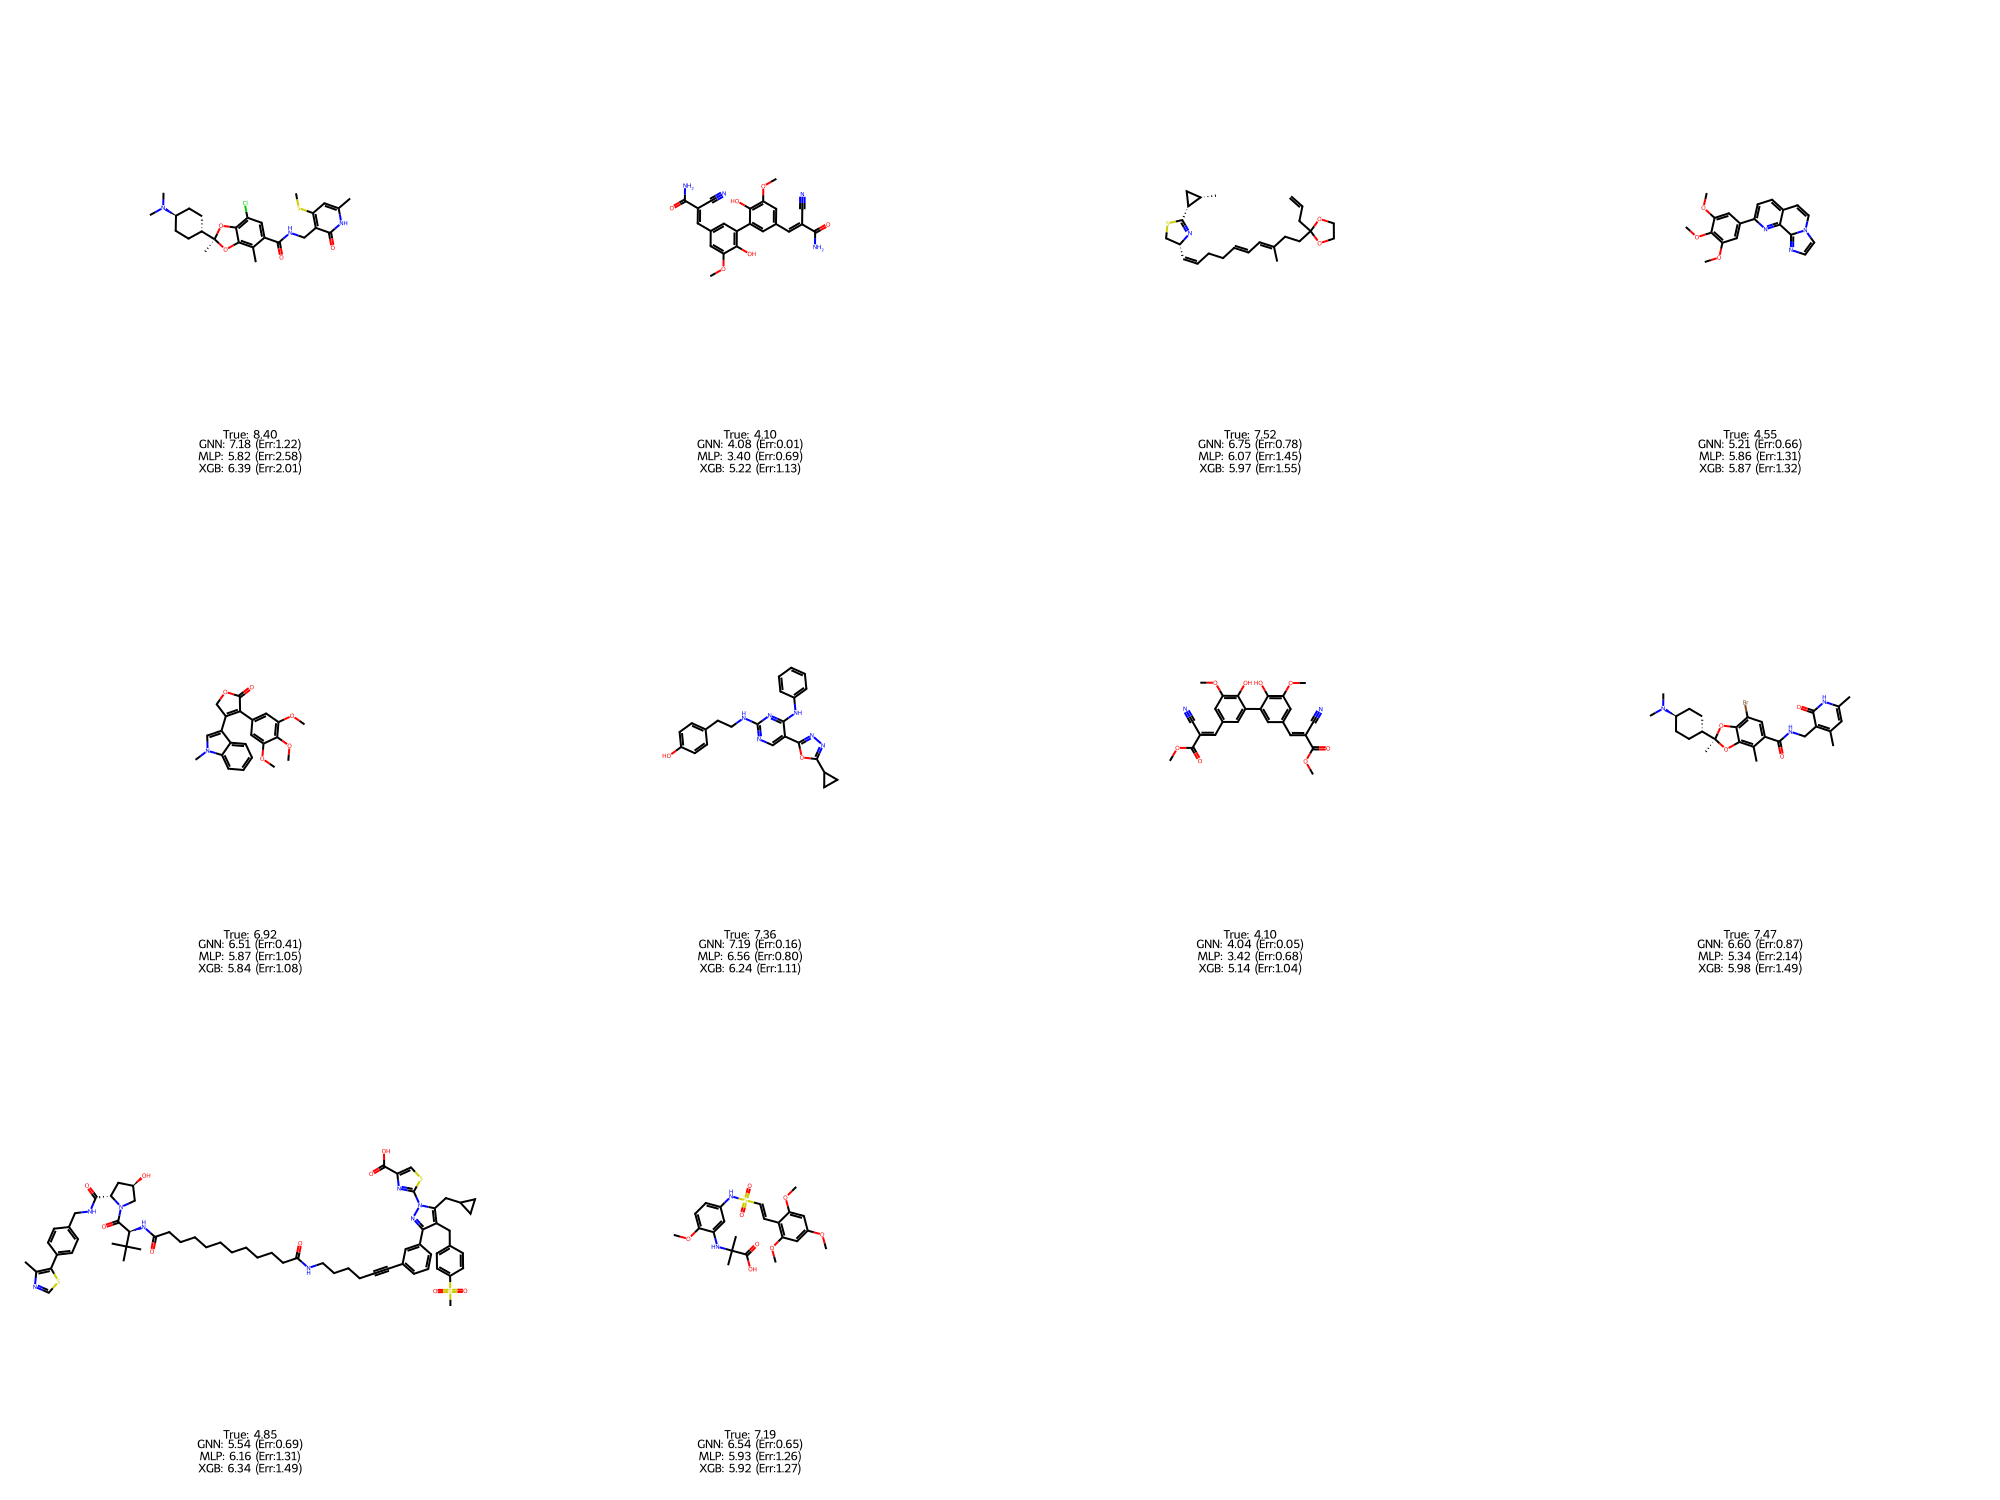

In [58]:
# Adjust error margin as needed
error_margin_gnn_outperforms = 0.5

# Calculate the advantage GNN has over MLP and XGBoost for each molecule
test_results_df["GNN_vs_MLP_Advantage"] = (
    test_results_df["MLP_Abs_Error"] - test_results_df["GNN_Abs_Error"]
)
test_results_df["GNN_vs_XGB_Advantage"] = (
    test_results_df["XGB_Abs_Error"] - test_results_df["GNN_Abs_Error"]
)

# Define the mask based on the error margin
gnn_outperforms_mask = (
    test_results_df["GNN_vs_MLP_Advantage"] > error_margin_gnn_outperforms
) & (test_results_df["GNN_vs_XGB_Advantage"] > error_margin_gnn_outperforms)

filtered_outperforms_df = test_results_df[gnn_outperforms_mask]
print(
    f"Total molecules where GNN overperformed by {error_margin_gnn_outperforms} error margin: {len(filtered_outperforms_df)}"
)

# Calculate the minimum advantage of the GNN
filtered_outperforms_df["Min_GNN_Advantage"] = filtered_outperforms_df[
    ["GNN_vs_MLP_Advantage", "GNN_vs_XGB_Advantage"]
].min(axis=1)

# Sort by the GNN minimum advantage in descending order
gnn_outperforms_df = (
    filtered_outperforms_df[gnn_outperforms_mask]
    .sort_values("Min_GNN_Advantage", ascending=False)
    .head(10)
)
display_molecules_with_predictions(
    gnn_outperforms_df, "Molecules Where GNN Significantly Outperformed Tabular Models (Top by advantage)"
)

#### 8.4.4. Visualize Molecules Where Tabular Models Outperformed GNN
This section visualizes five molecules from the test set where, contrary to the general trend, a tabular model (either MLP or XGBoost) yielded a **notably more accurate prediction** than the GNN. These cases serve as direct examples illustrating specific instances where the GNN's absolute error was significantly higher than that of a tabular model.

Total molecules where GNN underperformed by 1 error margin: 25

### Molecules Where a Tabular Model Outperformed GNN


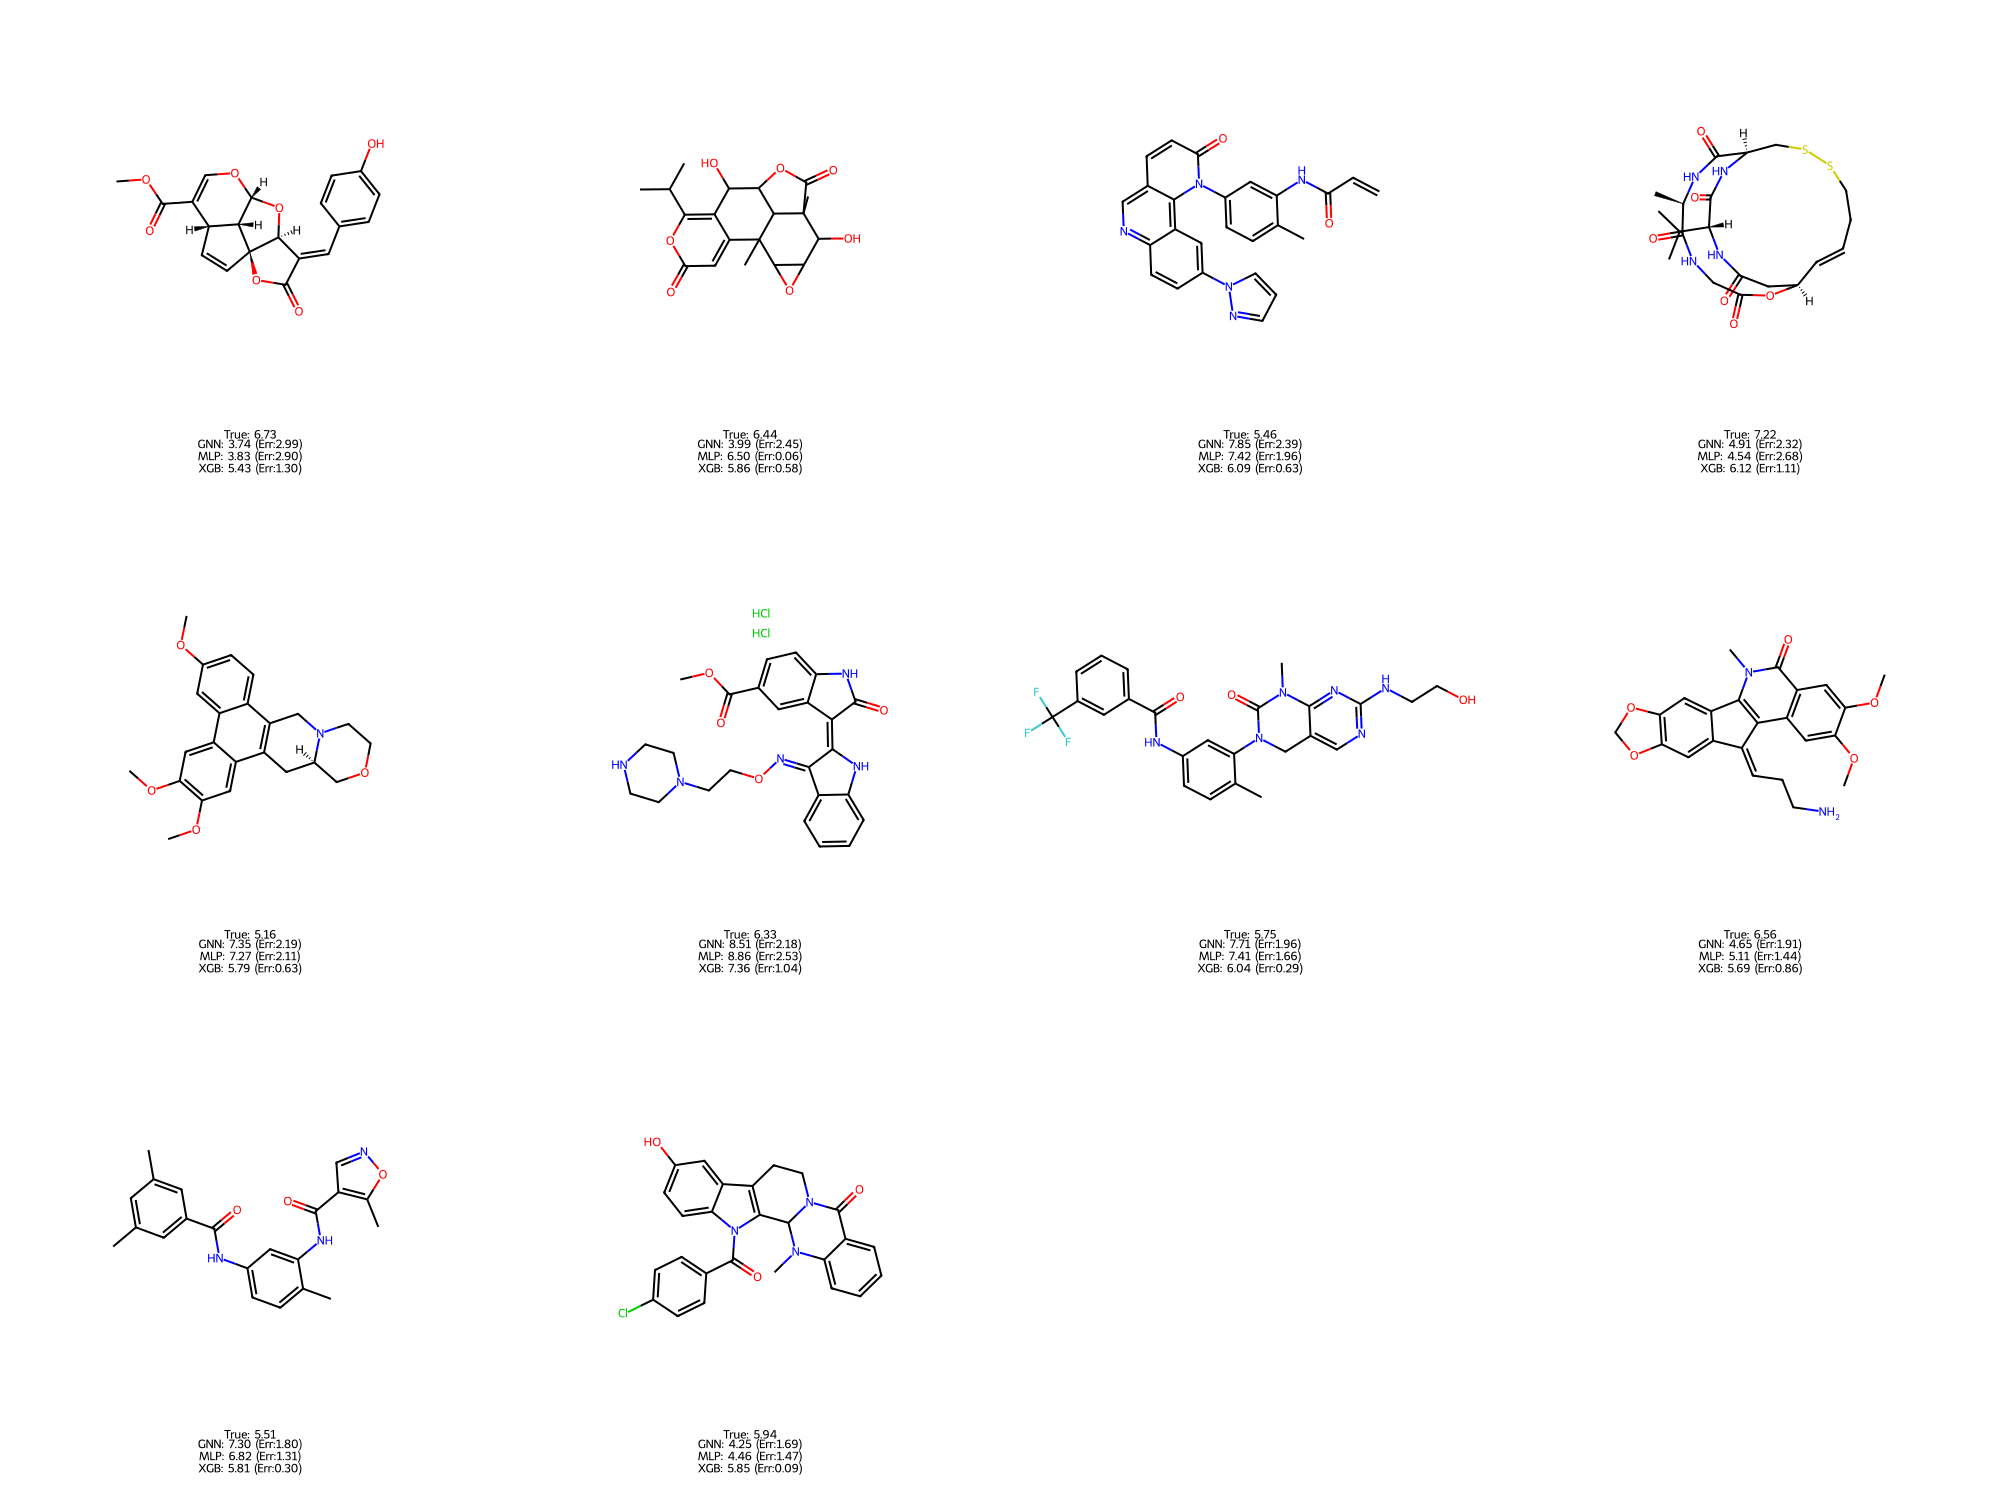

In [59]:
# Adjust error margin as needed
error_margin_gnn_underperforms = 1

# Calculate how much GNN's error is worse than MLP's and XGBoost's
test_results_df["GNN_vs_MLP_Underperformance"] = (
    test_results_df["GNN_Abs_Error"] - test_results_df["MLP_Abs_Error"]
)
test_results_df["GNN_vs_XGB_Underperformance"] = (
    test_results_df["GNN_Abs_Error"] - test_results_df["XGB_Abs_Error"]
)

gnn_underperforms_mlp_mask = (
    test_results_df["GNN_vs_MLP_Underperformance"] > error_margin_gnn_underperforms
)
gnn_underperforms_xgb_mask = (
    test_results_df["GNN_vs_XGB_Underperformance"] > error_margin_gnn_underperforms
)

filtered_underperforms_df = test_results_df[
    gnn_underperforms_mlp_mask | gnn_underperforms_xgb_mask
]
print(
    f"Total molecules where GNN underperformed by {error_margin_gnn_underperforms} error margin: {len(filtered_underperforms_df)}"
)

# Calculate the maximum underperformance to sort by the 'most underperformed' scenario
filtered_underperforms_df["Max_GNN_Underperformance"] = filtered_underperforms_df[
    ["GNN_vs_MLP_Underperformance", "GNN_vs_XGB_Underperformance"]
].max(axis=1)

# Sort by the maximum underperformance in descending order
gnn_underperforms_df = (
    filtered_underperforms_df[gnn_underperforms_mlp_mask | gnn_underperforms_xgb_mask]
    .sort_values("GNN_Abs_Error", ascending=False)
    .head(10)
)

display_molecules_with_predictions(
    gnn_underperforms_df, "Molecules Where a Tabular Model Outperformed GNN"
)

#### 8.4.5. Visualize Molecules Where All Models Struggled
This section focuses on molecules from the test set for which **all three models (XGBoost, MLP, and GNN) exhibited relatively high prediction errors**. These examples represent challenging prediction cases where none of the current modeling approaches were able to accurately estimate the pGI50 values


Total molecules where all models struggled with at least 1 error margin: 10

### Molecules Where All Models Struggled (High Errors)


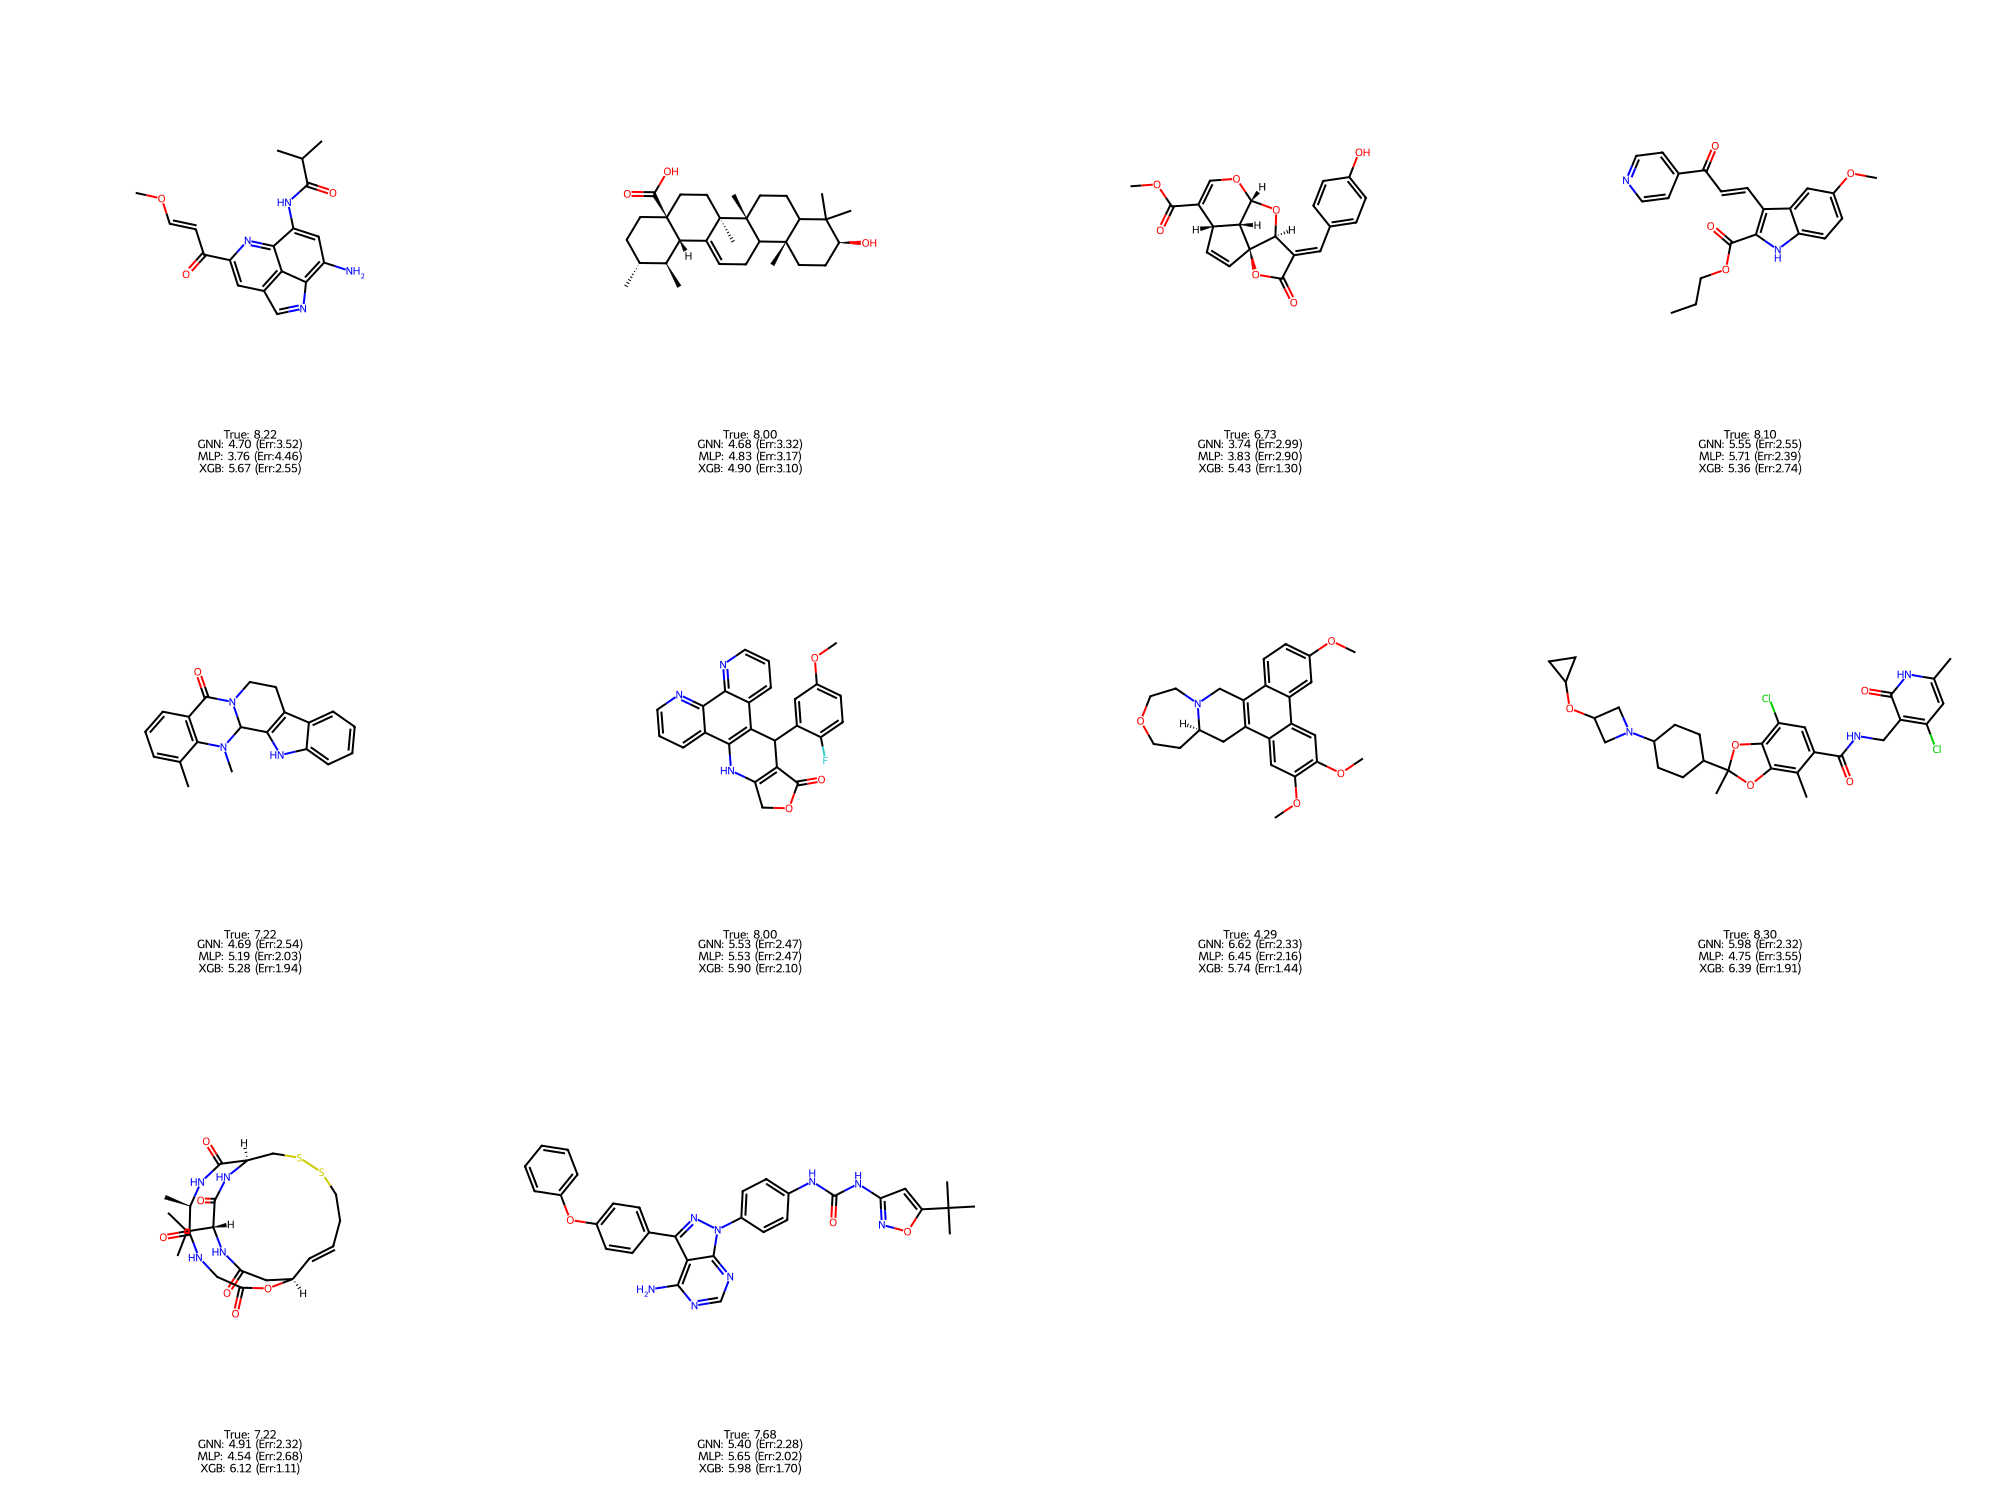

In [60]:
error_margin_all_models_struggle = 1
all_struggle_df = test_results_df[(test_results_df['GNN_Abs_Error'] > error_margin_all_models_struggle) & \
                                  (test_results_df['MLP_Abs_Error'] > error_margin_all_models_struggle) & \
                                  (test_results_df['XGB_Abs_Error'] > error_margin_all_models_struggle)].nlargest(10, 'GNN_Abs_Error')

print(
    f"Total molecules where all models struggled with at least {error_margin_all_models_struggle} error margin: {len(all_struggle_df)}"
)

display_molecules_with_predictions(
    all_struggle_df, "Molecules Where All Models Struggled (High Errors)"
)

#### 8.4.6. Visualize Molecules Best Predicted by GNN
Finally, this section highlights the molecules for which the GNN model achieved its **most precise predictions** on the test set (i.e., the lowest absolute errors). These examples showcase the GNN's strong predictive capabilities when it performs at its best, demonstrating its ability to accurately estimate `pGI50` for these specific compounds.


### GNN's Most Accurate Predictions (Lowest Errors)


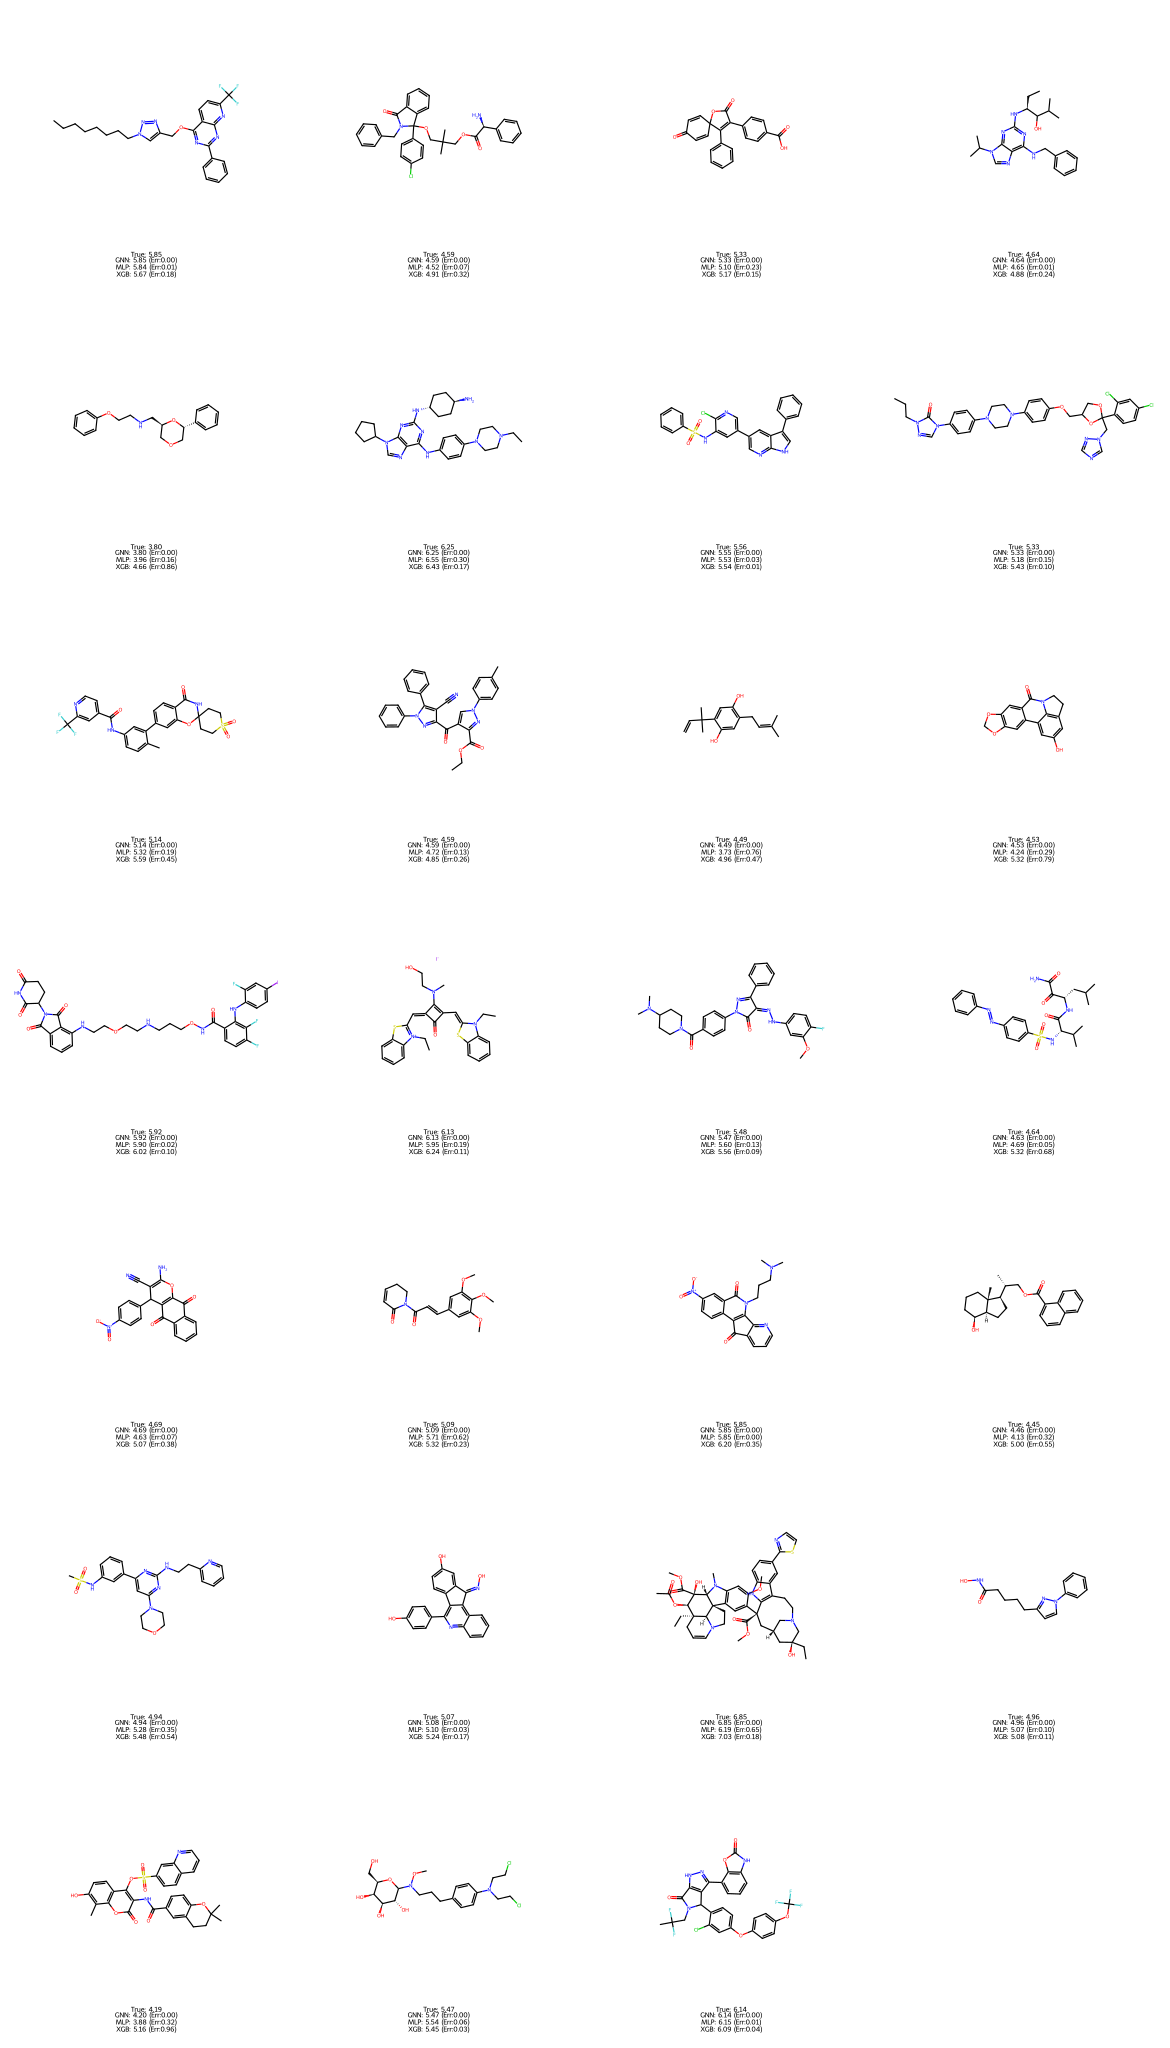

In [65]:
gnn_best_predictions_df = test_results_df.nsmallest(27, "GNN_Abs_Error")
display_molecules_with_predictions(
    gnn_best_predictions_df, "GNN's Most Accurate Predictions (Lowest Errors)"
)

---

## 9. Project Conclusion
This final section summarizes the key findings from the model comparison, highlighting how each model performed against the project's objective of predicting `pGI50`. It provides a verdict on the effectiveness of **leveraging specialized models** that are designed to capture the inherent nature of the data, as opposed to more generalized approaches.

### 9.1. Comparative Performance Summary
A concise summary of the quantitative performance metrics (RMSE and R2) for each model is presented, drawing direct comparisons and identifying the best-performing model based on the evaluation on the unseen test data.

The following table summarizes the test set performance for each model:

| Model   | RMSE   | R2     |
| :------ | :----- | :----- |
| XGBoost | 0.6957 | 0.4951 |
| MLP     | 0.6408 | 0.5715 |
| GNN     | 0.6114 | 0.6100 |

From these results, the **Graph Neural Network (GNN) model emerged as the top performer**, achieving the lowest RMSE (0.6114) and the highest R2 score (0.6100). The Multi-Layer Perceptron (MLP) also showed strong performance (RMSE 0.6408, R2 0.5715), outperforming the XGBoost model (RMSE 0.6957, R2 0.4951).

### 9.2. Leveraging Data Structure: GNN vs. Generalized Models
The superior performance of the **Graph Neural Network (GNN) strongly supports the hypothesis that models specialized for leveraging the inherent graph structure of molecular data can offer a distinct advantage** in `pGI50` prediction.
The GNN, by directly processing atom-bond connectivity and local neighborhood information, was able to extract more discriminative features, leading to an RMSE that is approximately 0.03 (4.6%) lower than the MLP and 0.08 (11.6%) lower than XGBoost. Correspondingly, its R2 score is higher, indicating it explains more variance in the target variable.

While both MLP and XGBoost demonstrated reasonable predictive capabilities based on carefully engineered tabular features, the GNN's slight but consistent edge highlights the power of its inherent bias for graph-structured data. This suggests that explicitly modeling the relational information within molecules allows the GNN to capture complex patterns that are less accessible to models relying solely on flattened feature vectors. However, a closer look at **specific edge cases revealed instances where simpler tabular models achieved comparable or even slightly superior accuracy**, suggesting areas for further refinement in the GNN's generalizability across all molecular subsets. This is particularly promising for generalization to new/unfamiliar chemical entities, where handcrafted features might be less robust.

### 9.3. Overall Project Learnings and Future Work
This project successfully demonstrated a robust end-to-end machine learning pipeline for molecular property prediction, emphasizing systematic data preparation, hyperparameter optimization, and rigorous model evaluation. The comparative analysis provided clear insights into the strengths and weaknesses of different modeling approaches for molecular data.

Future work could involve:
* **Exploring More Advanced GNN Architectures:** Investigating more sophisticated GNN layers (e.g., attention mechanisms, message passing variants) or deeper GNN models to potentially capture more intricate molecular patterns.
* **Incorporating 3D Molecular Information:** Integrating 3D structural data (e.g., bond angles) into the GNN input could further enrich the model's understanding of molecular properties.
* **Expanding Hyperparameter Search:** Conducting more extensive hyperparameter optimization, especially for the deep learning models, potentially with longer training times and more trials, to uncover additional performance gains.
* **Ensemble Modeling:** Exploring ensemble methods that combine predictions from the GNN with insights from the MLP or XGBoost could lead to even more robust and accurate predictions.
* **Model Interpretability:** Investigating techniques to enhance the interpretability of the GNN model, providing deeper chemical insights into which molecular substructures or interactions drive the `pGI50` predictions.

---